In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter
from scipy.interpolate import UnivariateSpline
from scipy.stats import entropy 
from scipy.stats import chisquare
from scipy.stats import ttest_ind


In [52]:
popular_color_features = "../Final_features/vine_features_ordered.csv"
unpopular_color_features = "../Final_features/Unpopular2016_aesthetic_ordered.csv"
aesthetic_color_features = "../Logs/aesthetic_features_6.csv"
aesthetic_csv = "../Final_features/total_aesthetic.pk"


In [3]:
def readFeatureFile(color_features):
    with open(color_features) as g:
        featureLines = g.readlines()
    print len(featureLines)
    return featureLines

def readAesFeatuers(lines):
    features = []
    for line in lines:
        components = line.strip().split('|')
        features.append([float(x) for x in components[1:]])
    return features

def readFeatures(lines):
    ids = []
    features = []
    feats = []
    
    components = lines[0].strip().split(',')
    ID = components[0].strip().split('_')[0]
    
    for line in lines:
        components = line.strip().split('|')
        postId = components[0].strip().split('_')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            #Take median of all frames in a vine for all the attributes
            median = np.median(feats,0)
            for i in range(len(median)):
                if np.isnan(median[i]):
                    median[i] = 0.0
            features.append(median)
            feats[:] = []
            feats.append([float(x) for x in components[1:]]) 
        else :
            feats.append([float(x) for x in components[1:]]) 
            
    return features, ids
    

In [4]:
pop_features = readFeatureFile(popular_color_features)
unpop_features = readFeatureFile(unpopular_color_features)
aesthetic_features = readFeatureFile(aesthetic_color_features)

50187
21733
1149


In [5]:
popfeatures_matrix , popposts = readFeatures(pop_features)

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3567: RuntimeWarning: Invalid value encountered in median for 3 results
  RuntimeWarning)


In [6]:
unpopfeatures_matrix , unpopposts = readFeatures(unpop_features)

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3567: RuntimeWarning: Invalid value encountered in median for 1 results
  RuntimeWarning)


In [7]:
aes_feature = readAesFeatuers(aesthetic_features)

In [9]:
print len(popposts) , len(unpopposts)

6751 11723


In [48]:
totalPosts = np.asarray(popposts + unpopposts)
print totalPosts.shape
print totalPosts[1]

(18474,)
1281874693611532288


In [49]:
totalFeats = np.asarray(popfeatures_matrix + unpopfeatures_matrix)
print totalFeats.shape
print totalFeats[15012]

(18474, 19)
[ -1.97269995e-14   4.29733404e+00   4.35666971e-01   2.49023438e-02
   3.80859375e-02   3.13328493e-01   1.90694444e-01   8.86440146e-01
   4.61755756e-02   1.27490974e-01   0.00000000e+00   0.00000000e+00
   1.20529997e-01  -1.28924876e-02   5.53736062e-02   9.59813807e-02
   5.61592882e-01   7.67108616e-02   2.00000000e+00]


In [51]:
totalMap = np.append(totalPosts.reshape((-1,1)),totalFeats , axis=1)
print totalMap[15012]

['1384696746931826688' '-1.97269994996e-14' '4.29733404131'
 '0.435666970725' '0.02490234375' '0.0380859375' '0.313328493495'
 '0.190694444444' '0.886440145673' '0.0461755756228' '0.12749097429' '0.0'
 '0.0' '0.120529996543' '-0.0128924876433' '0.0553736062438'
 '0.0959813807005' '0.561592881944' '0.0767108616108' '2.0']


In [56]:
import pickle
f = open(aesthetic_csv , "w+")
pickle.dump(totalMap, f)
f.close()

In [57]:
f = open(aesthetic_csv , "r+")
feats = pickle.load(f)
f.close()
print feats[104]

['1282183367848497152' '-1.10801774134e-14' '8.58375272881'
 '0.0526322079498' '0.0009765625' '0.00244140625' '0.540988032549'
 '0.446194058642' '0.850565751465' '0.0610475900012' '0.225965286793' '0.0'
 '0.0' '0.00567806518798' '-0.463018808309' '0.0122138666405'
 '0.00352911656145' '0.53609375' '0.00407062926302' '1.0']


In [58]:
unpop_aes_features = np.asarray(unpopfeatures_matrix)
aes_feats = np.asarray(aes_feature)
pop_aes_features = np.asarray(popfeatures_matrix)

print unpop_aes_features.shape , aes_feats.shape , pop_aes_features.shape

(11723, 19) (1149, 19) (6751, 19)


In [59]:
samples_pop = np.random.choice(pop_aes_features.shape[0],1000)
samples_unpop = np.random.choice(unpop_aes_features.shape[0], 1000)
samples_aes = np.random.choice(aes_feats.shape[0], 1000)
sampledpop_aes_features = pop_aes_features[samples_pop,:]
sampledunpop_aes_features = unpop_aes_features[samples_unpop,:]
sampled_aes = aes_feats[samples_aes,:]

In [60]:
print sampledpop_aes_features.shape , sampledunpop_aes_features.shape

(1000, 19) (1000, 19)


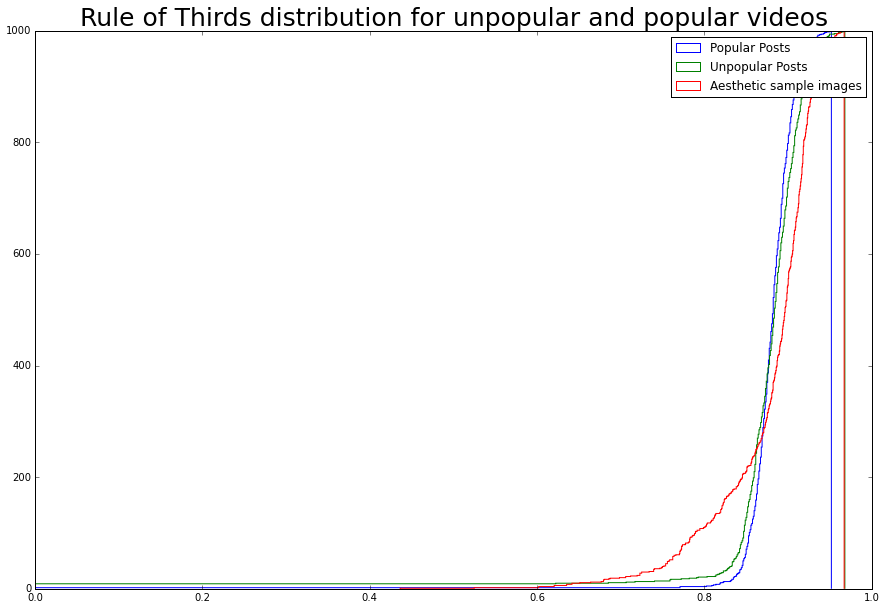

0.880676420329 0.00204364307182
0.879130363743 0.00569438295976
0.878654485253 0.00370492880686


In [61]:
num = 7
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampled_aes[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Rule of Thirds distribution for unpopular and popular videos', fontsize = 25)
plt.show()

print np.mean(sampledpop_aes_features[:,num]) , np.var(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.var(unpop_aes_features[:,num])
print np.mean(sampled_aes[:,num]) , np.var(sampled_aes[:,num])

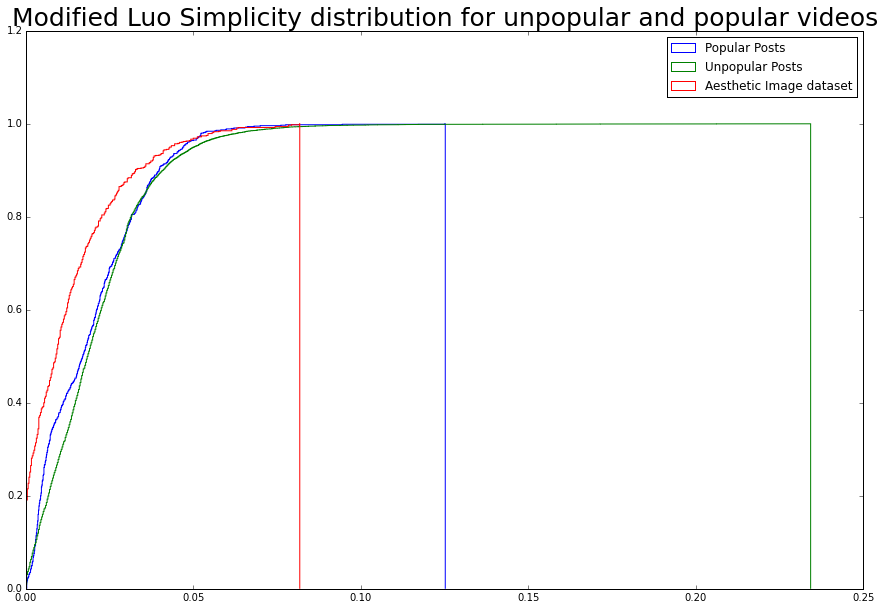

0.0190728759766 0.000236108317599
0.0210370580603 0.000275447693707
0.0131071777344 0.000218633117139


In [62]:
num = 4
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(unpop_aes_features[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampled_aes[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic Image dataset'])
plt.title('Modified Luo Simplicity distribution for unpopular and popular videos', fontsize = 25)
plt.show()
print np.mean(sampledpop_aes_features[:,num]) , np.var(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.var(unpop_aes_features[:,num])
print np.mean(sampled_aes[:,num]) , np.var(sampled_aes[:,num])

In [63]:
for i in range(sampledunpop_aes_features.shape[1]):
    print "Index %d" %i
    print "Aesthetic images: %0.3f , %0.3f , %0.3f "%( np.mean(aes_feats[:,i]), np.median(aes_feats[:,i]) , np.var(aes_feats[:,i]) )
    print "Popolar Vines: %0.3f , %0.3f , %0.3f "%( np.mean(sampledpop_aes_features[:,i]), np.median(sampledpop_aes_features[:,i]) , np.var(sampledpop_aes_features[:,i]) )
    print "Unpopular Vines: %0.3f , %0.3f , %0.3f "%( np.mean(sampledunpop_aes_features[:,i]), np.median(sampledunpop_aes_features[:,i]) , np.var(sampledunpop_aes_features[:,i]) )
    print "\n"
                                                                                                  

Index 0
Aesthetic images: 0.000 , -0.000 , 0.000 
Popolar Vines: -0.000 , -0.000 , 0.000 
Unpopular Vines: 0.000 , -0.000 , 0.000 


Index 1
Aesthetic images: 51.049 , 30.228 , 5267.701 
Popolar Vines: 30.818 , 16.021 , 1953.713 
Unpopular Vines: 20.359 , 9.262 , 1154.299 


Index 2
Aesthetic images: 0.113 , 0.084 , 0.010 
Popolar Vines: 0.156 , 0.136 , 0.011 
Unpopular Vines: 0.186 , 0.158 , 0.017 


Index 3
Aesthetic images: 0.009 , 0.005 , 0.000 
Popolar Vines: 0.013 , 0.011 , 0.000 
Unpopular Vines: 0.015 , 0.013 , 0.000 


Index 4
Aesthetic images: 0.013 , 0.009 , 0.000 
Popolar Vines: 0.019 , 0.017 , 0.000 
Unpopular Vines: 0.021 , 0.018 , 0.000 


Index 5
Aesthetic images: 0.179 , 0.161 , 0.009 
Popolar Vines: 0.239 , 0.196 , 0.021 
Unpopular Vines: 0.170 , 0.156 , 0.011 


Index 6
Aesthetic images: 0.316 , 0.089 , 0.158 
Popolar Vines: 0.183 , 0.119 , 0.036 
Unpopular Vines: 0.168 , 0.107 , 0.033 


Index 7
Aesthetic images: 0.879 , 0.899 , 0.004 
Popolar Vines: 0.881 , 0.882 ,

In [64]:
print entropy(sampledpop_aes_features, sampled_aes, base=None)
print entropy(sampledunpop_aes_features, sampled_aes, base=None)


[        inf  1.0740328   0.62258476  0.98472327         inf  0.32401897
  1.67809649  0.00508898  0.52685218  0.48532657         inf         inf
         inf         inf         inf         inf  0.03740865         inf
         inf]
[        inf  1.21749232  0.62220616  0.84948486         inf  0.35061901
  1.93116098  0.01231139  0.51965497  0.6652394          inf         inf
         inf         inf         inf         inf  0.08236659         inf
         inf]


/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:2493: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / sum(pk, axis=0)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:2500: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / sum(qk, axis=0)


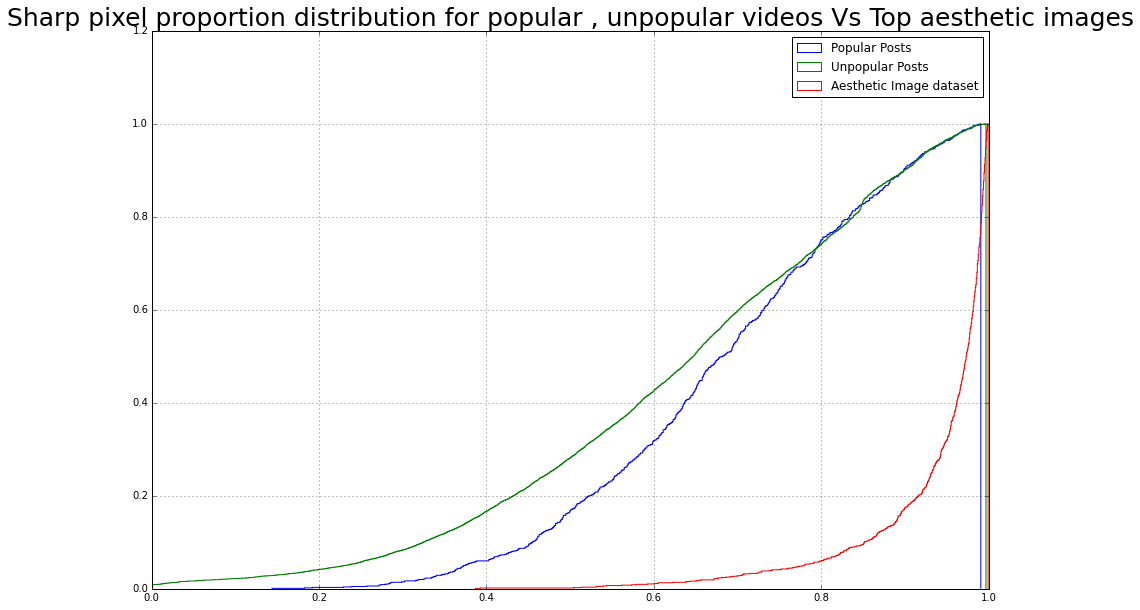

0.676331512346 0.028188274644
0.624103813433 0.0489511353592
0.946141540071 0.00661623716038


In [65]:
num = 16
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0 )
plt.hist(unpop_aes_features[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(aes_feats[:,num], 1000, normed=1,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' ,'Aesthetic Image dataset'])
plt.title('Sharp pixel proportion distribution for popular , unpopular videos Vs Top aesthetic images', fontsize = 25)
plt.grid()
plt.show()
print np.mean(sampledpop_aes_features[:,num]) , np.var(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.var(unpop_aes_features[:,num])
print np.mean(sampled_aes[:,num]) , np.var(sampled_aes[:,num])

In [66]:
print np.mean(sampledpop_aes_features[:,16]) , np.median(sampledpop_aes_features[:,16])
print np.mean(unpop_aes_features[:,16]) , np.median(unpop_aes_features[:,16])
print np.mean(aes_feats[:,16]) , np.median(aes_feats[:,16])

0.676331512346 0.682149281443
0.624103813433 0.6478515625
0.943023870488 0.973773333333


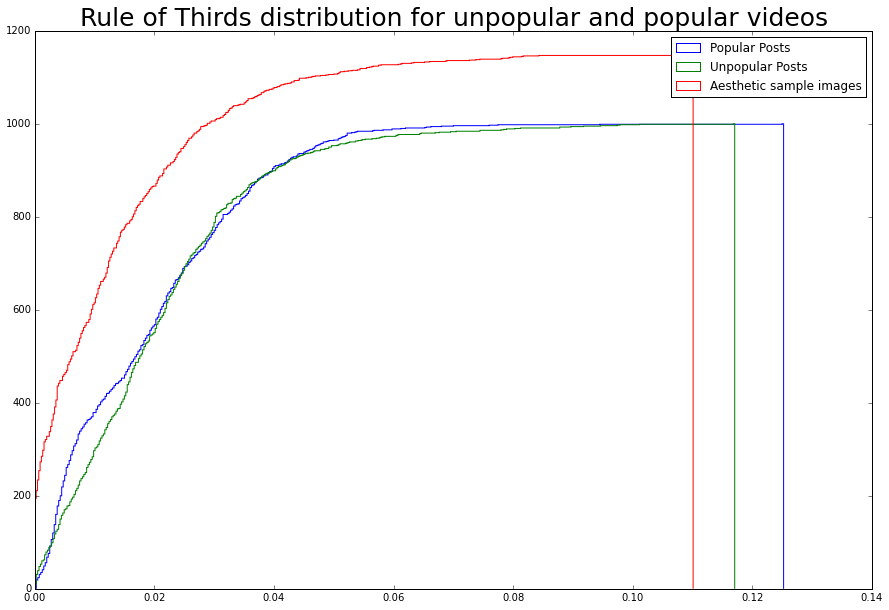

In [67]:
fig, ax = plt.subplots()
num = 4
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 500, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 500, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(aes_feats[:,num], 500, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Rule of Thirds distribution for unpopular and popular videos', fontsize = 25)
plt.show()

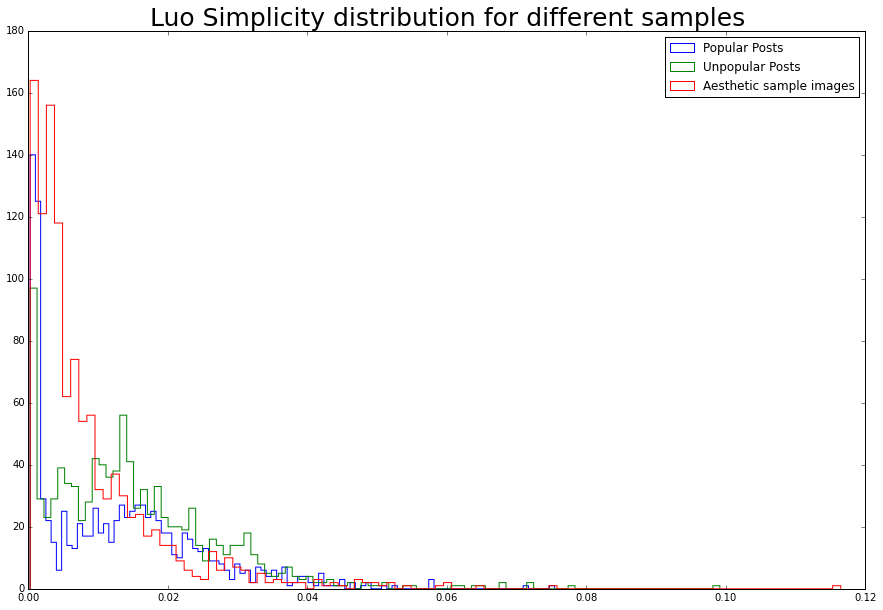

0.01284765625 0.01123046875
0.0155908561328 0.013671875
0.00880691090078 0.005126953125
2.16009277083e-17
1.11908703943e-37


In [68]:
fig, ax = plt.subplots()
num = 3
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.hist(aes_feats[:,num], 100, normed=0,histtype='step', cumulative=False, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Luo Simplicity distribution for different samples', fontsize = 25)
plt.show()

print np.mean(sampledpop_aes_features[:,num]) , np.median(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.median(unpop_aes_features[:,num])
print np.mean(aes_feats[:,num]) , np.median(aes_feats[:,num])
t, p = ttest_ind( sampledpop_aes_features[:,num], sampled_aes[:,num])
print p
t, p = ttest_ind( sampledunpop_aes_features[:,num], sampled_aes[:,num])
print p


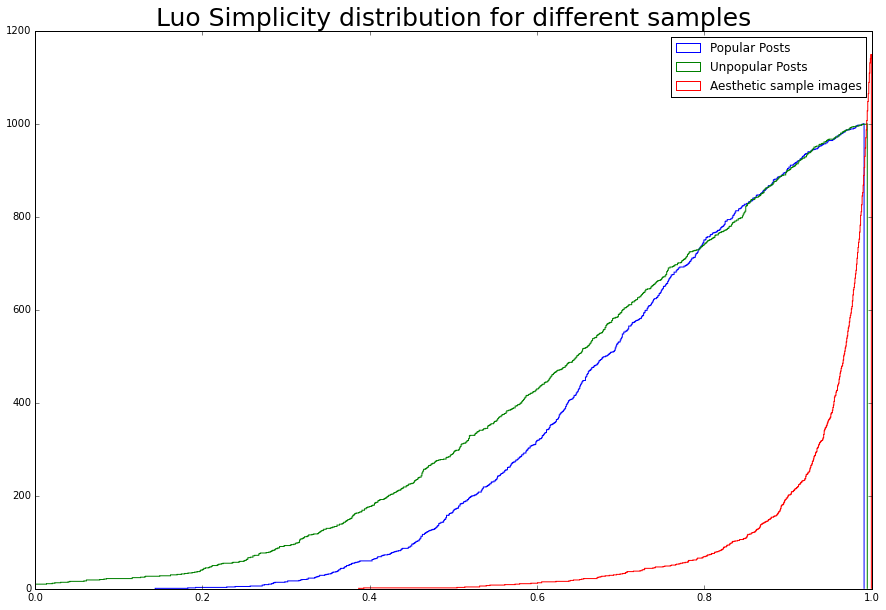

0.676331512346 0.682149281443
0.624103813433 0.6478515625
0.943023870488 0.973773333333


In [69]:
fig, ax = plt.subplots()
num = 16
fig.set_size_inches(15, 10)
plt.hist(sampledpop_aes_features[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(sampledunpop_aes_features[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.hist(aes_feats[:,num], 1000, normed=0,histtype='step', cumulative=True, linewidth = 1.0)
plt.legend(['Popular Posts', 'Unpopular Posts' , 'Aesthetic sample images'])
plt.title('Luo Simplicity distribution for different samples', fontsize = 25)
plt.show()

print np.mean(sampledpop_aes_features[:,num]) , np.median(sampledpop_aes_features[:,num])
print np.mean(unpop_aes_features[:,num]) , np.median(unpop_aes_features[:,num])
print np.mean(aes_feats[:,num]) , np.median(aes_feats[:,num])